# Example usage of data-drive-quadtrature annealing optimization for spectral fluxes

### by Neal Ma

This notebook shows an example of using the data-driven-quadrature package for estimating spectral fluxes. 

TODO:

- Data availability and attribution

In [8]:
# import libraries
import numpy as np
import xarray as xr
import cvxpy as cp
import datadrivenquadrature as ddq

# not required but for visualization
import matplotlib.pyplot as plt

In [9]:
# Load in data
x_file_path = './../data/pyarts_training_72000_all_levels.h5'
x = xr.open_mfdataset(x_file_path, combine = 'nested', concat_dim = 'column', engine = "netcdf4")

# # Extract flattened spectral fluxes
# x_sup = np.reshape(np.array(x['spectral_fluxes']), (55*50, x['spectral_fluxes'].shape[-1]))
# Extract flattened reference fluxes
y_ref = np.array(x['reference_fluxes'].data).flatten()

In [10]:
# Print dataset, reference fluxes, and axis length
print("x:\n", x)
print("y:\n", np.asarray(y_ref).shape)
print("axis_len:\n", (x['spectral_fluxes'].shape)[-1])

x:
 <xarray.Dataset>
Dimensions:            (half_level: 55, column: 50, spectral_coord: 72120,
                        level: 54)
Coordinates:
  * half_level         (half_level) int64 0 1 2 3 4 5 6 ... 48 49 50 51 52 53 54
  * level              (level) int64 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * column             (column) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * spectral_coord     (spectral_coord) float32 0.0002 0.0202 ... 3.26e+03
Data variables:
    spectral_fluxes    (half_level, column, spectral_coord) float64 dask.array<chunksize=(55, 50, 72120), meta=np.ndarray>
    reference_fluxes   (half_level, column) float64 dask.array<chunksize=(55, 50), meta=np.ndarray>
    reference_heating  (column, level) float64 dask.array<chunksize=(50, 54), meta=np.ndarray>
    pressures          (column, half_level) float32 dask.array<chunksize=(50, 55), meta=np.ndarray>
y:
 (2750,)
axis_len:
 72120


In [11]:
# calculate the scale to use for integration axis normalization
norm_vector = ddq.find_normalization_vector(x, ['spectral_coord'])

# number of integration points
n_integration_points = 15

# use norm1 as cost function
def user_cost_fnc(y, y_hat):
    cost = cp.norm(y - y_hat)
    return cost

def map_func(x, point_set, x_sup=None):
    point_idxs = [point[0] for point in point_set]
    points = np.array(x.spectral_fluxes[:,:,point_idxs].values).reshape((55*50, n_integration_points))
    return points

# set params in dictionary
params = {}
integration_list = ['spectral_coord']
params['integration_list'] = integration_list
params['n_points'] = n_integration_points
params['epochs'] = 100
params['success'] = 25
params['block_size'] = 50
params['random_seed'] = 1
params['verbose'] = 2

In [12]:
history = ddq.optimize(x, y_ref / norm_vector[0][0], user_cost_fnc, map_func, params)

EPOCH: 1	AVG COST: 7.287e-02	BEST COST: 2.973e-02
EPOCH: 2	AVG COST: 5.577e-02	BEST COST: 2.973e-02
EPOCH: 3	AVG COST: 5.945e-02	BEST COST: 2.973e-02
EPOCH: 4	AVG COST: 8.155e-02	BEST COST: 2.973e-02
EPOCH: 5	AVG COST: 6.079e-02	BEST COST: 2.973e-02
EPOCH: 6	AVG COST: 6.256e-02	BEST COST: 2.973e-02
EPOCH: 7	AVG COST: 4.962e-02	BEST COST: 2.973e-02
EPOCH: 8	AVG COST: 7.034e-02	BEST COST: 2.973e-02
EPOCH: 9	AVG COST: 9.454e-02	BEST COST: 2.973e-02
EPOCH: 10	AVG COST: 3.776e-02	BEST COST: 2.904e-02
EPOCH: 11	AVG COST: 1.219e-01	BEST COST: 2.904e-02
EPOCH: 12	AVG COST: 8.841e-02	BEST COST: 2.904e-02
EPOCH: 13	AVG COST: 1.102e-01	BEST COST: 2.904e-02
EPOCH: 14	AVG COST: 5.767e-02	BEST COST: 2.904e-02
EPOCH: 15	AVG COST: 3.771e-02	BEST COST: 2.433e-02
EPOCH: 16	AVG COST: 6.910e-02	BEST COST: 1.767e-02
EPOCH: 17	AVG COST: 8.016e-02	BEST COST: 1.767e-02
EPOCH: 18	AVG COST: 1.939e-01	BEST COST: 1.767e-02
EPOCH: 19	AVG COST: 6.616e-02	BEST COST: 1.767e-02
EPOCH: 20	AVG COST: 6.185e-02	BEST COST:

dict_keys(['cost', 'point_sets', 'weight_sets', 'temperature_history', 'best'])
(16, 23)
0.01766762331992
[[32822], [46184], [5376], [56965], [28756], [35865], [70223], [62967], [34307], [22555], [69171], [31727], [16501], [35530], [52340]]
[1.87470037e-08 9.97434039e-02 1.31802344e-01 1.20095093e-02
 1.77214402e-02 8.80638045e-03 3.39929088e-01 8.87473266e-02
 2.13807529e-02 2.75116453e-02 1.67482386e-01 5.36588365e-03
 5.85326877e-02 4.99369046e-03 1.59734424e-02]


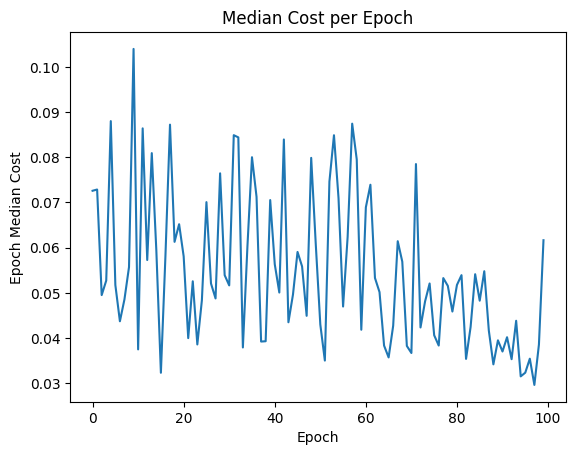

In [16]:
# calculate mean and median costs for each block
mean_costs = []
median_costs = []
for cost in history['cost']:
    mean_costs.append(np.mean(cost))
    median_costs.append(np.median(cost))

# plot median costs and print best point set, weights, and associated cost
plt.plot(np.arange(len(median_costs)), median_costs)
plt.xlabel('Epoch')
plt.ylabel('Epoch Median Cost')
plt.title('Median Cost per Epoch')
best = history['best']
print(history.keys())
print(best)
print(history['cost'][best[0]][best[1]])
print(history['point_sets'][best[0]][best[1]])
print(history['weight_sets'][best[0]][best[1]])